## Генерация изображений с помощью Stable Diffusion

В этом ноутбуке мы исследуем разные возможности по генерации изображений. Для начала, создадим директорию, куда мы будем складывать все результаты генерации.

In [1]:
import os
os.makedirs('output',exist_ok=True)

Также установим полезные библиотеки:

In [1]:
%pip install -q shwarsutils diffusers sentencepiece


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from shwars.utils import display_images

### Text to Image

Простейшая генерация - из текста в изображение. Можно загрузить готовую модель, и при необходимости поверх неё до-обученный стиль LoRA. В последнем случае не забывайте использовать специальный промпт.

In [2]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

model_name = "./GRBX_LoRA"

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(model_name)
_ = pipe.to("cuda")

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-03-14 15:51:27.133577: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 15:51:28.677485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-14 15:51:34.466564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading pipeline components...

Генерируем изображение:

100%|██████████| 30/30 [00:09<00:00,  3.22it/s]


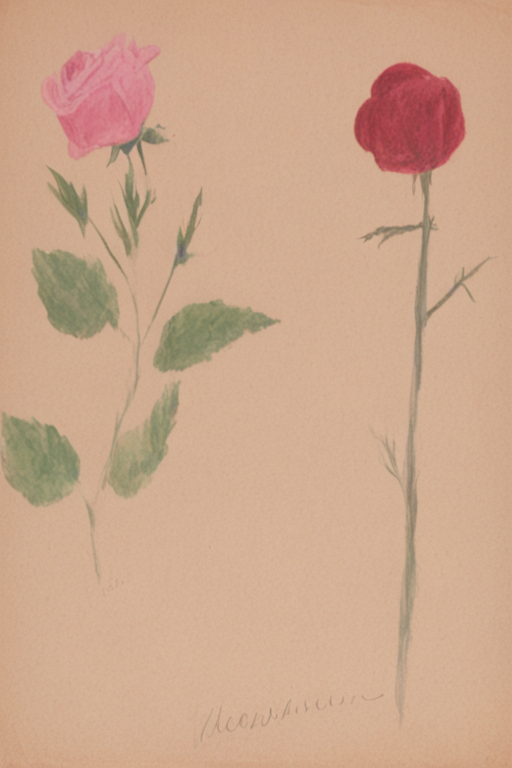

In [45]:
prompt = "drawing of a rose, gerbarium in GRBX style"

res = pipe(
    prompt,
    num_inference_steps=30,
    height=768,
    width=512
).images[0]

res

Сохраняем его, если понравилось:

In [39]:
res.save(f"output/res.jpg")

> Если хватает памяти GPU, то можно генерировать сразу по несколько изображений (2-3), указывая параметр `num_generated_images`

Можем сгенерировать изображение, сохраняя все промежуточные шаги генерации:

In [ ]:
from PIL import Image
import numpy as np

prompt = "drawing of a maple leaf on white background, gerbarium in GRBX style"

# Number of inference steps
num_inference_steps = 50

def save_intermediate_images(step, timestep, latents):
    """
    Callback function to save intermediate images during the denoising process.
    """
    with torch.no_grad():
        image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor).sample
        image = (image / 2 + 0.5).clamp(0, 1)  # Normalize to [0,1]
        image = image.permute(0, 2, 3, 1).cpu().numpy()[0]  # Convert to numpy
        img = Image.fromarray((image*255).astype(np.uint8))
        img.save(f"output/step_{step:03d}.png")

# Generate image while capturing intermediate frames
pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    callback=save_intermediate_images,
    callback_steps=1  # Capture every step
)

100%|██████████| 50/50 [01:38<00:00,  1.97s/it]


StableDiffusionXLPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7FACECACB700>])

Можно смонтировать все шаги диффузии вместе в небольшое видео:

In [ ]:
!ffmpeg -r 10 -i output/step_%03d.png -vcodec libx264 diffusion_process.mp4

## Inpainting

Inpainting - это режим для дорисовки фрагментов изображения. Возьмём за образец икону из Ферапонтового монастыря:

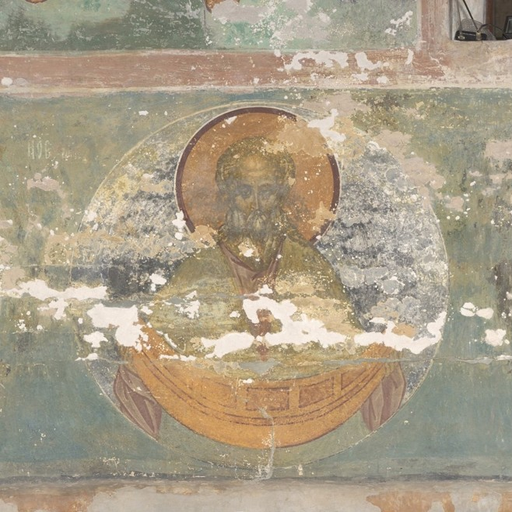

In [4]:
from PIL import Image

img = Image.open('images/restoration.jpg')
img = img.crop((0,0,img.width//2-10,img.height)).resize((512,512),Image.Resampling.LANCZOS)
img

Извлечём маску, взяв все пиксели изображения, которые ярче некоторого порога, а также применив фильтр размытия (Blur) для сглаживания мелких зон.

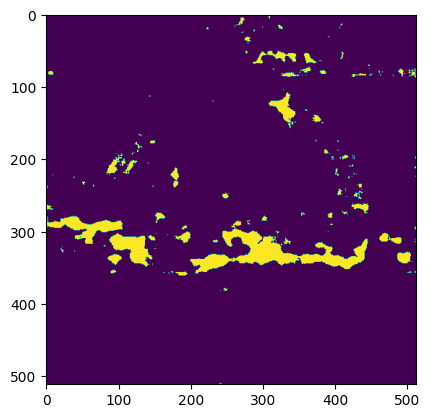

In [6]:
import matplotlib.pyplot as plt
from PIL import ImageFilter
import numpy as np

mask = np.array(img.convert("L").filter(ImageFilter.BLUR))>200
mask = mask.astype(np.uint8)
plt.imshow(mask)

Загружаем модель для Inpainting:

In [15]:
from diffusers import AutoPipelineForInpainting
import torch

pipe = None
pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    #"stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16"
)
_ = pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Генерируем результирующее изображение:

100%|██████████| 49/49 [00:35<00:00,  1.36it/s]


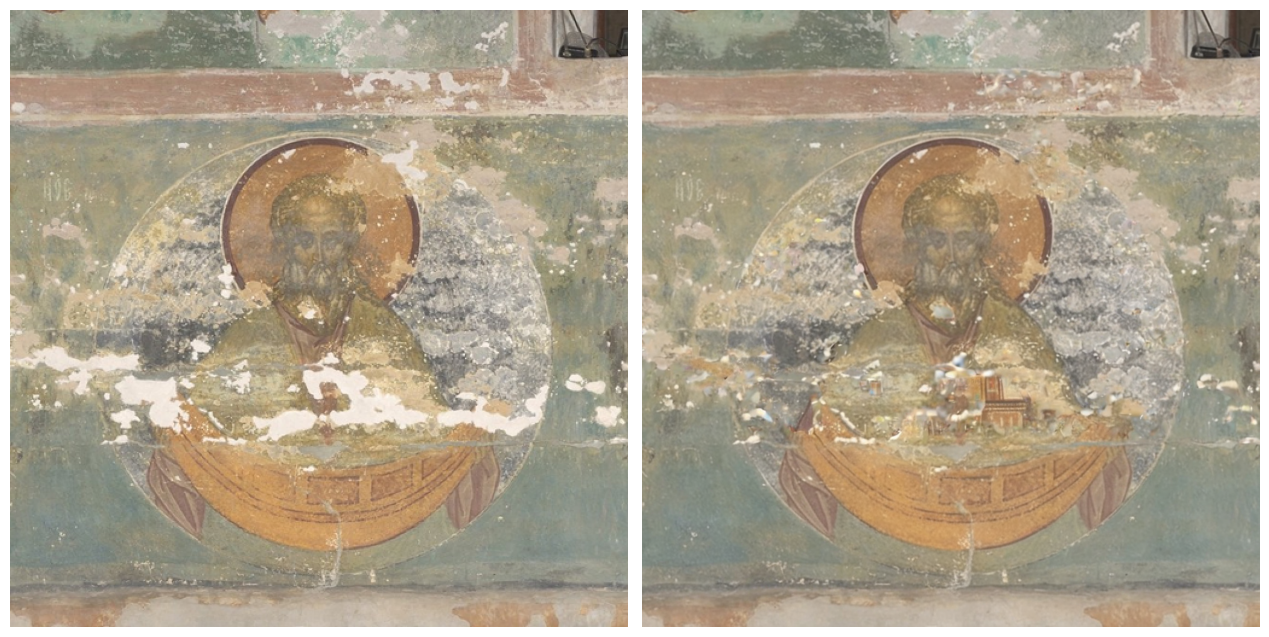

In [14]:
res = pipe(prompt="old restored russian orthodox icon, by Andrey Rublev",
           image=img,
           mask_image=mask).images[0]
display_images([img,res])

Конечно, результат будет лучше, если мы вручную нарисуем маску, которая будет частично перекрывать фрагменты изображения, чтобы белых пустот не оставалось.

## Генерация в Stable Diffusion 3.5 Medium

Чтобы генерировать более качественные изображение, можно использовать более современные модели, которые, однако, требуют больше памяти. Поэтому мы будем загружать модель в режиме квантизации, и необходимо будет переключиться на более мощную виртуальную машину (g1.1/V100).

In [1]:
from diffusers import BitsAndBytesConfig, SD3Transformer2DModel
from diffusers import StableDiffusion3Pipeline
import torch

model_id = "stabilityai/stable-diffusion-3.5-medium"

pipe = None

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
model_nf4 = SD3Transformer2DModel.from_pretrained(
    model_id,
    subfolder="transformer",
    quantization_config=nf4_config,
    torch_dtype=torch.float16
)

pipe = StableDiffusion3Pipeline.from_pretrained(
    model_id, 
    transformer=model_nf4,
    torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-03-16 19:19:41.465502: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 19:19:41.526034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-16 19:19:42.641685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading pipeline components...

Token indices sequence length is longer than the specified maximum sequence length for this model (200 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. the skin is textured with the familiar grid pattern of a waffle, each square filled with a glistening sheen of syrup. the environment combines the natural habitat of a hippo with elements of a breakfast table setting, a river of warm, melted butter, with oversized utensils or plates peeking out from the lush, pancake - like foliage in the background, a towering pepper mill standing in for a tree. as the sun rises in this fantastical world, it casts a warm, buttery glow over the scene. the creature, content in its butter river, lets out a yawn. nearby, a flock of birds take flight']
Token indices sequence length is longer than the specified maximum sequence length for this model (200 > 77). Running this 

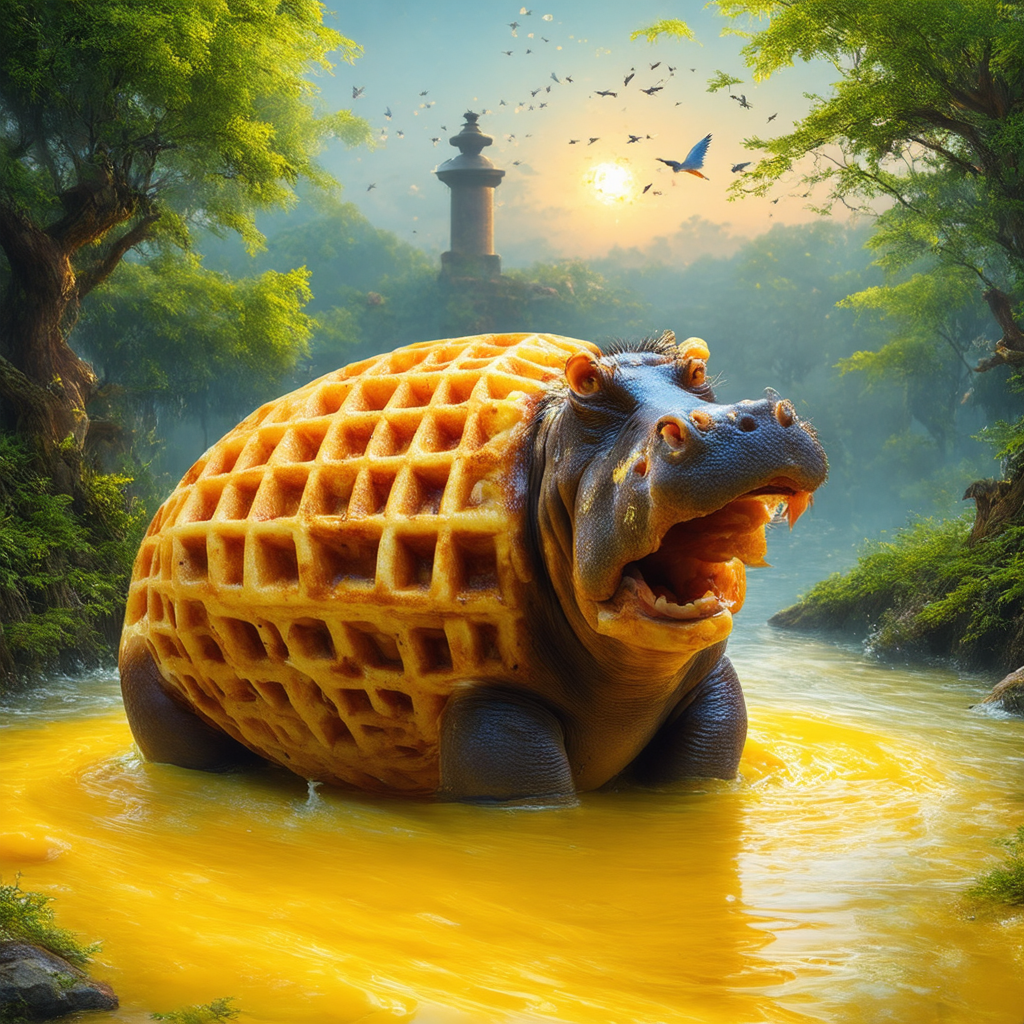

In [6]:
prompt = "A whimsical and creative image depicting a hybrid creature that is a mix of a waffle and a hippopotamus, basking in a river of melted butter amidst a breakfast-themed landscape. It features the distinctive, bulky body shape of a hippo. However, instead of the usual grey skin, the creature's body resembles a golden-brown, crispy waffle fresh off the griddle. The skin is textured with the familiar grid pattern of a waffle, each square filled with a glistening sheen of syrup. The environment combines the natural habitat of a hippo with elements of a breakfast table setting, a river of warm, melted butter, with oversized utensils or plates peeking out from the lush, pancake-like foliage in the background, a towering pepper mill standing in for a tree.  As the sun rises in this fantastical world, it casts a warm, buttery glow over the scene. The creature, content in its butter river, lets out a yawn. Nearby, a flock of birds take flight"

image = pipe(
    prompt=prompt,
    num_inference_steps=40,
    guidance_scale=4.5,
    max_sequence_length=512,
).images[0]
image

Если нужно сгенерировать изображения по списку промптов из файла `prompts.txt`, то можно использовать код ниже:

In [2]:
with open('prompts_en.txt',encoding='utf-8') as f:
    prompts = f.readlines()
    
for p in prompts:
    image = pipe(
    prompt=p,
    num_inference_steps=40,
    guidance_scale=4.5).images[0]
    fn = p.replace(':','')
    image.save(f"output/{fn}.jpg")

100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


Если вам нужно другое соотношение сторон изображения или разрешение, то при вызове `pipe` можно указать параметры `width` и `height` (они должны быть кратны 8).

Для получения изображения ещё большего разрешения можно использовать Stable Diffusion Upscaler, качественно увеличивающий разрешение изображения в 4 раза. При этом для его работы необходимо с каждым изображением передавать промпт, который может быть исходным, либо другим (например, *картина маслом, широкие мазки*). Последнее позволяет добавить исходному изображению немного другую мелкую фактуру. 

Для начала загружаем модель:

In [1]:
pipe = None

from diffusers import StableDiffusionUpscalePipeline
import torch

model_id = "stabilityai/stable-diffusion-x4-upscaler"
pipeline = StableDiffusionUpscalePipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-03-16 19:30:44.871933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


Теперь проходимся по картинкам из директории `outputs`.

> Если размерность картинки больше 512x512, нам может не хватить объема памяти GPU при использовании V-100. Поэтому мы уменьшим размер картинки вдвое перед увеличением разрешения в 4 раза. Это приведёт к общему апскейлингу в 2 раза, но в целом картинка получится более проработанной, особенно в деталях. Вы можете также поэкспериментировать с более объемными GPU, и с тем, какой максимальный размер изображения перед апскейлингом влезает в память.

In [4]:
from glob import glob
from PIL import Image

queue = [ fn for fn in glob('output/*')]
for fn in queue:
    # формируем промпт из имени файла, но можно задать общий промпт для всех картинок
    # в соответствии со стилем, или считать промпты из файла
    prompt = fn[fn.find('/')+1:fn.rfind('.')]
    img = Image.open(fn)
    if img.size[0]>=1024:
        img = img.resize((img.size[0]//2,img.size[1]//2),Image.Resampling.LANCZOS)
    uimage = pipeline(prompt=prompt, image=img).images[0]
    uimage.save(f"output/{prompt}_upscaled.jpg")


100%|██████████| 75/75 [00:56<00:00,  1.33it/s]


Есть причина, почему мы сначала генерируем все изображения в директорию `output`, а потом занимаемся апскейлингом. Дело в том, что мы имеем дело с достаточно большими моделями, и одновременная генерация файлов и их апскейлинг потребовали ли бы загрузить в память обе модели одновременно, что приводит к существенно бОльшим требованиям к ресурсам.